In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import camelot

In [22]:
malla = pd.read_excel("Horarios 2023-1 - GUIA FINAL.xlsx", usecols=lambda x: x != 0, header=None, skiprows=2, nrows=453)

In [23]:
malla

,1,2,3,4,5
0,BFI01\nA,LU 10-12\nMI 10-12,R1-450 / zoom152\nR1-460 / zoom156,J. TELLO,40.0
1,NaN,VI 08-10\nVI 13-15,J3-182A / zoom91 (P)\nLAB F / zoom158 (L),A. PAREDES\nA. ALTAMIRANO,NaN
2,BFI01\nB,LU 14-16\nMI 14-16,J3-182B / zoom162\nJ3-182A / zoom162,S. CUSTODIO,40.0
3,NaN,VI 08-10\nVI 08-10,J3-232 / zoom157 (P)\nLAB FI / zoom163 / LAB F...,J. AMORETTI\nA. NAUPA,NaN
4,BFI01\nC,JU 08-10\nMA 08-10,J3-242 / zoom153\nJ3-232 / zoom152,C. ONCEBAY,40.0
...,...,...,...,...,...
446,NaN,MA 19-22,R1-430 / zoom25,C. CCAHUANCAMA,NaN
447,CL002\nC,MI 18-19,R1-421 / zoom25,C. CCAHUANCAMA,30.0
448,NaN,MI 19-22,R1-421 / zoom25,C. CCAHUANCAMA,NaN
449,CL002\nD,JU 13-14,R1-421 / zoom24,C. CCAHUANCAMA,30.0


In [183]:
file = "doc4.pdf"

# Lee el pdf en una lista de DataFrames
tables = camelot.read_pdf(file, pages = "all", flavor='stream')
# Para el primer DataFrame de la primera pagina
mallad = tables[0].df
mallad = mallad.drop(mallad.index[:5])
nuevas_columnas = mallad.iloc[0]
mallad = mallad[1:].set_axis(nuevas_columnas, axis=1)
mallad = mallad[['Codigo', 'Curso','Cred.', 'Pre_Requisitos']]
mallad['index'] = 0

# Resetear el índice del DataFrame
mallad = mallad.reset_index(drop=True)
ciclos = 0
indice = 0
for i, row in mallad.iterrows():
    if row['Codigo'][:1] == '_':
        indice = 0
        ciclos += 1
    mallad.at[i + 1, 'index'] = indice
    indice += 1
    

def mallaendospaginas(mallad, ciclos):
    # Para el segundo DataFrame de la primera pagina
    mallad2 = tables[1].df
    mallad2 = mallad2.drop(mallad2.index[:5])
    mallad2 = mallad2.iloc[:,[0]]
    mallad2 = mallad2[0].str.split('\n', expand=True)
    nuevas_columnas2 = mallad2.iloc[0]
    mallad2 = mallad2[1:].set_axis(nuevas_columnas2, axis=1)
    for i, row in mallad2.iterrows():
        if row['Codigo'][:1] == '_':
            indice = 0
            ciclos += 1
        mallad2.at[i + 1, 'index'] = indice
        indice += 1
        if ciclos == 12:
            mallad2 = mallad2.drop(mallad2.index[i-4:])
            break
    #Concatenar los datas frames resultantes
    mallad = pd.concat([mallad, mallad2])
    mallad = mallad.reset_index(drop=True)
    return mallad 

#Verifica si tdv no se completa la malla
if ciclos < 11:
    mallad = mallaendospaginas(mallad, ciclos)
    
#Detalles
mallad = mallad[mallad['Codigo'].str[:1] != '_']
mallad = mallad[mallad['Codigo'].notnull()]
mallad['index'] = mallad['index'].astype(int)
mallad = mallad.drop(mallad.index[-1])
mallad.set_index('index', inplace=True)
mallad = mallad.rename_axis(None)


In [171]:
mallad

5,Codigo,Curso,Cred.,Pre_Requisitos
0,BIC01,INTRODUCCION A LA COMPUTACION-,2,
1,BMA01,CALCULO DIFERENCIAL-,5,
2,BQU01,QUIMICA I-,5,
3,BRC01,REDACCION Y COMUNICACION-,2,
4,FB101,GEOMETRIA ANALITICA-,3,
...,...,...,...,...
3,SI035,PROYECTO DE TESIS EN INGENIERIA SISTEMAS II-,2,SI901
4,SI055,GESTION DE PROYECTOS-,2,GE902
5,SI075,AUDITORIA DE SISTEMAS-,3,SI904
6,SI085,APLICACION DE NEGOCIOS ELECTRONICOS-,3,SI807 SI903


In [184]:
mallad.iloc[56:61]

5,Codigo,Curso,Cred.,Pre_Requisitos
2,SI902,INGENIERIA DE SISTEMAS DE SERVICIO-,3,GE801
3,SI903,IMPLEMENTACION DE SISTEMAS-,2,GE803 SI805
4,SI904,SEGURIDAD DE SISTEMAS-,3,SI805
0,BAE01,ACTIVIDADES EXTRACURRICULARES-,1,None
1,BIE01,IDIOMA EXTRANJERO O LENGUA NATIVA EN EL NIVEL ...,2,None


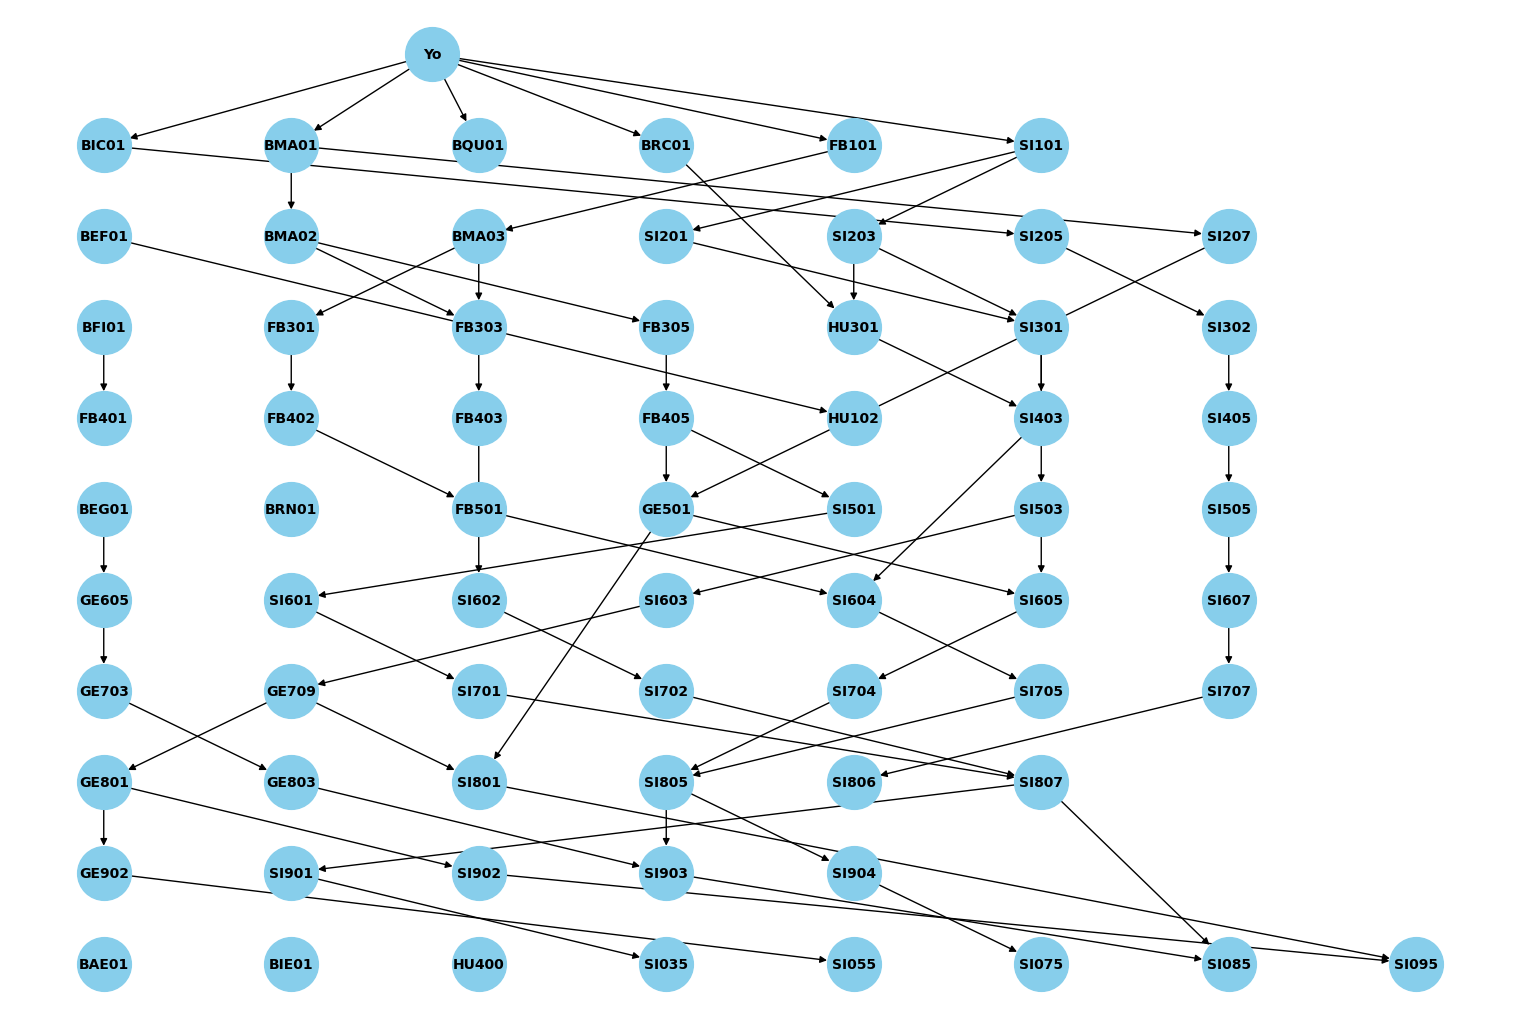

In [185]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir un nodo para el estudiante
G.add_node('Yo')

# Añadir nodos al grafo
for index, row in mallad.iterrows():
    G.add_node(row['Codigo'], 
               name=row['Curso'], 
               )

# Añadir aristas al grafo
for index, row in mallad.iterrows():
    if pd.notna(row['Pre_Requisitos']) and row['Pre_Requisitos'] != '':
        prereqs = row['Pre_Requisitos'].split(' ')
        for prereq in prereqs:
            if prereq in G.nodes:  # Solo añadir la arista si el prerrequisito existe como nodo
                G.add_edge(prereq, row['Codigo'])

# Conectar el nodo del estudiante a todos los cursos del primer semestre
first_semester_nodes = []
z = 0
for i, row in mallad.iterrows():
    if i == 0: 
        z += 1
    if z == 2:
        break
    first_semester_nodes.append(row['Codigo'])

for node in first_semester_nodes:
    G.add_edge('Yo', node)

# Crear un layout personalizado
pos = {'Yo': (max(mallad.index) / 2, 0)}  # El nodo del estudiante estará en la parte superior y en el centro
current_semester = 0
y = 0
x_spacing = 2  # Espaciado horizontal entre nodos
y_spacing = 2  # Espaciado vertical entre semestres
for index, row in mallad.iterrows():
    if index == 0:
        y += 1
    pos[row['Codigo']] = (index * x_spacing, -y * y_spacing)  # Los nodos con índice 0 estarán en la parte superior

# Crear una figura más grande
plt.figure(figsize=(15, 10))

# Dibujar el grafo
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='k', font_size=10, font_weight='bold')

# Ajustar los límites de los ejes para aumentar el espacio entre los nodos
plt.xlim(-1, max([v[0] for v in pos.values()]) + 1)
y_values = [v[1] for v in pos.values()]
plt.ylim(min(y_values) - 1, max(y_values) + 1)

# Mostrar el grafo
plt.show()